<a href="https://colab.research.google.com/github/rahiakela/edureka-deep-learning-with-tensorflow/blob/module-6-recurrent-neural-networks/1_spam_detection_using_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing an RNN in TensorFlow

We implement an RNN in TensorFlow to predict spam/ham from texts

In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops

In [0]:
ops.reset_default_graph()

# Start a graph
sess = tf.Session()

# Set RNN parameters
epochs = 20
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

# Download or open data
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [0]:
if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    # Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')

    print('text_',text_data)
    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

print(len(text_data))

In [0]:
text_data = [x.split('\t') for x in text_data if len(x) >= 1]
print(text_data)
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]
print(text_data_target)
print(text_data_train)

In [0]:
# Create a text cleaning function
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return (text_string)


# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]

In [0]:
# Change texts into numeric vectors
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

# Shuffle and split data
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Split train/test set
ix_cutoff = int(len(y_shuffled) * 0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

In [0]:
# Create placeholders
x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

# Create embedding
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)
# embedding_output_expanded = tf.expand_dims(embedding_output, -1)

In [0]:
# Define the RNN cell
# tensorflow change >= 1.0, rnn is put into tensorflow.contrib directory. Prior version not test.
if tf.__version__[0] >= '1':
    cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_size)
else:
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

# Get output of RNN sequence
output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

In [0]:
# Loss function
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out,
                                                        labels=y_output)  # logits=float32, labels=int32
loss = tf.reduce_mean(losses)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
sess.run(init)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
model_path = "/home/rakesh/MachineLearning/Tensorflow"

In [10]:
# Start training
for epoch in range(epochs):

    # Shuffle training data
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train) / batch_size) + 1
    # TO DO CALCULATE GENERATIONS ExACTLY
    for i in range(num_batches):
        # Select train data
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i + 1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]

        # Run train step
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob: 0.5}
        sess.run(train_step, feed_dict=train_dict)

    # Run loss and accuracy for training
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)

    # Run Eval Step
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob: 1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch + 1, temp_test_loss, temp_test_acc))

    save_path = saver.save(sess,'my_model',global_step=1000)

Epoch: 1, Test Loss: 0.69, Test Acc: 0.81
Epoch: 2, Test Loss: 0.69, Test Acc: 0.81
Epoch: 3, Test Loss: 0.67, Test Acc: 0.81
Epoch: 4, Test Loss: 0.65, Test Acc: 0.83
Epoch: 5, Test Loss: 0.62, Test Acc: 0.83
Epoch: 6, Test Loss: 0.59, Test Acc: 0.83
Epoch: 7, Test Loss: 0.56, Test Acc: 0.84
Epoch: 8, Test Loss: 0.54, Test Acc: 0.84
Epoch: 9, Test Loss: 0.53, Test Acc: 0.84
Epoch: 10, Test Loss: 0.51, Test Acc: 0.85
Epoch: 11, Test Loss: 0.5, Test Acc: 0.85
Epoch: 12, Test Loss: 0.49, Test Acc: 0.85
Epoch: 13, Test Loss: 0.49, Test Acc: 0.85
Epoch: 14, Test Loss: 0.48, Test Acc: 0.85
Epoch: 15, Test Loss: 0.48, Test Acc: 0.86
Epoch: 16, Test Loss: 0.47, Test Acc: 0.86
Epoch: 17, Test Loss: 0.47, Test Acc: 0.86
Epoch: 18, Test Loss: 0.47, Test Acc: 0.86
Epoch: 19, Test Loss: 0.46, Test Acc: 0.86
Epoch: 20, Test Loss: 0.46, Test Acc: 0.86


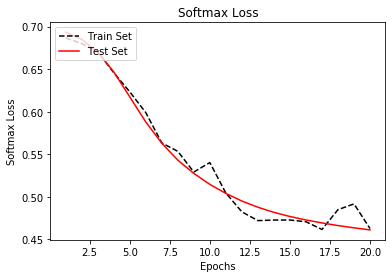

In [11]:
# Plot loss over time
epoch_seq = np.arange(1, epochs + 1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

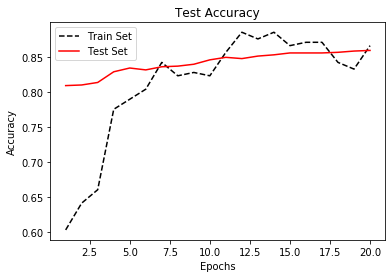

In [12]:
# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()